In [1]:
import os
import urllib.request as urllib
import tarfile
import sys
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
HEIGHT, WIDTH, DEPTH = 96, 96, 3
N_CLASSES = 10
SIZE = HEIGHT*WIDTH*DEPTH
DATA_DIR = './stl10_data'
# DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# DATA_URL = 'stl10_binary.tar.gz'
TRAIN_DATA_PATH = DATA_DIR + '/stl10_binary/train_X.bin'
TEST_DATA_PATH = DATA_DIR+'/stl10_binary/test_X.bin'
TRAIN_LABELS_PATH = DATA_DIR + '/stl10_binary/train_y.bin'
TEST_LABELS_PATH = DATA_DIR + '/stl10_binary/test_y.bin'
CLASS_NAMES_PATH = DATA_DIR + '/stl10_binary/class_names.txt'

In [3]:
def read_labels(path_to_labels):
  with open(path_to_labels, 'rb') as f:
    labels = np.fromfile(f, dtype=np.uint8)
    return labels

def read_all_images(path_to_data):
  with open(path_to_data, 'rb') as f:
    everything = np.fromfile(f, dtype=np.uint8)
    images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))
    images = np.transpose(images, (0, 3, 2, 1))
    return images

def download_and_extract():
  if all((
     os.path.exists(TRAIN_DATA_PATH),
     os.path.exists(TEST_DATA_PATH),
     os.path.exists(TRAIN_LABELS_PATH),
     os.path.exists(TEST_LABELS_PATH)
  )):
    return

  dest_directory = DATA_DIR
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)

  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                                                    float(count*block_size)/ float(total_size)*100.0))
      sys.stdout.flush()
    filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
    print('Downloaded', filename)
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def load_dataset():
#   download_and_extract()

  x_train = read_all_images(TRAIN_DATA_PATH)
  y_train = read_labels(TRAIN_LABELS_PATH)
  x_test = read_all_images(TEST_DATA_PATH)
  y_test = read_labels(TEST_LABELS_PATH)

  x_train = x_train.astype('float32')
  x_train = (x_train - 127.5) / 127.5
  x_test = x_test.astype('float32')
  x_test = (x_test - 127.5) / 127.5

  y_train -= 1
  y_test -= 1

  y_train = keras.utils.to_categorical(y_train, N_CLASSES)
  y_test = keras.utils.to_categorical(y_test, N_CLASSES)

  return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5000, 96, 96, 3) (5000, 10) (8000, 96, 96, 3) (8000, 10)


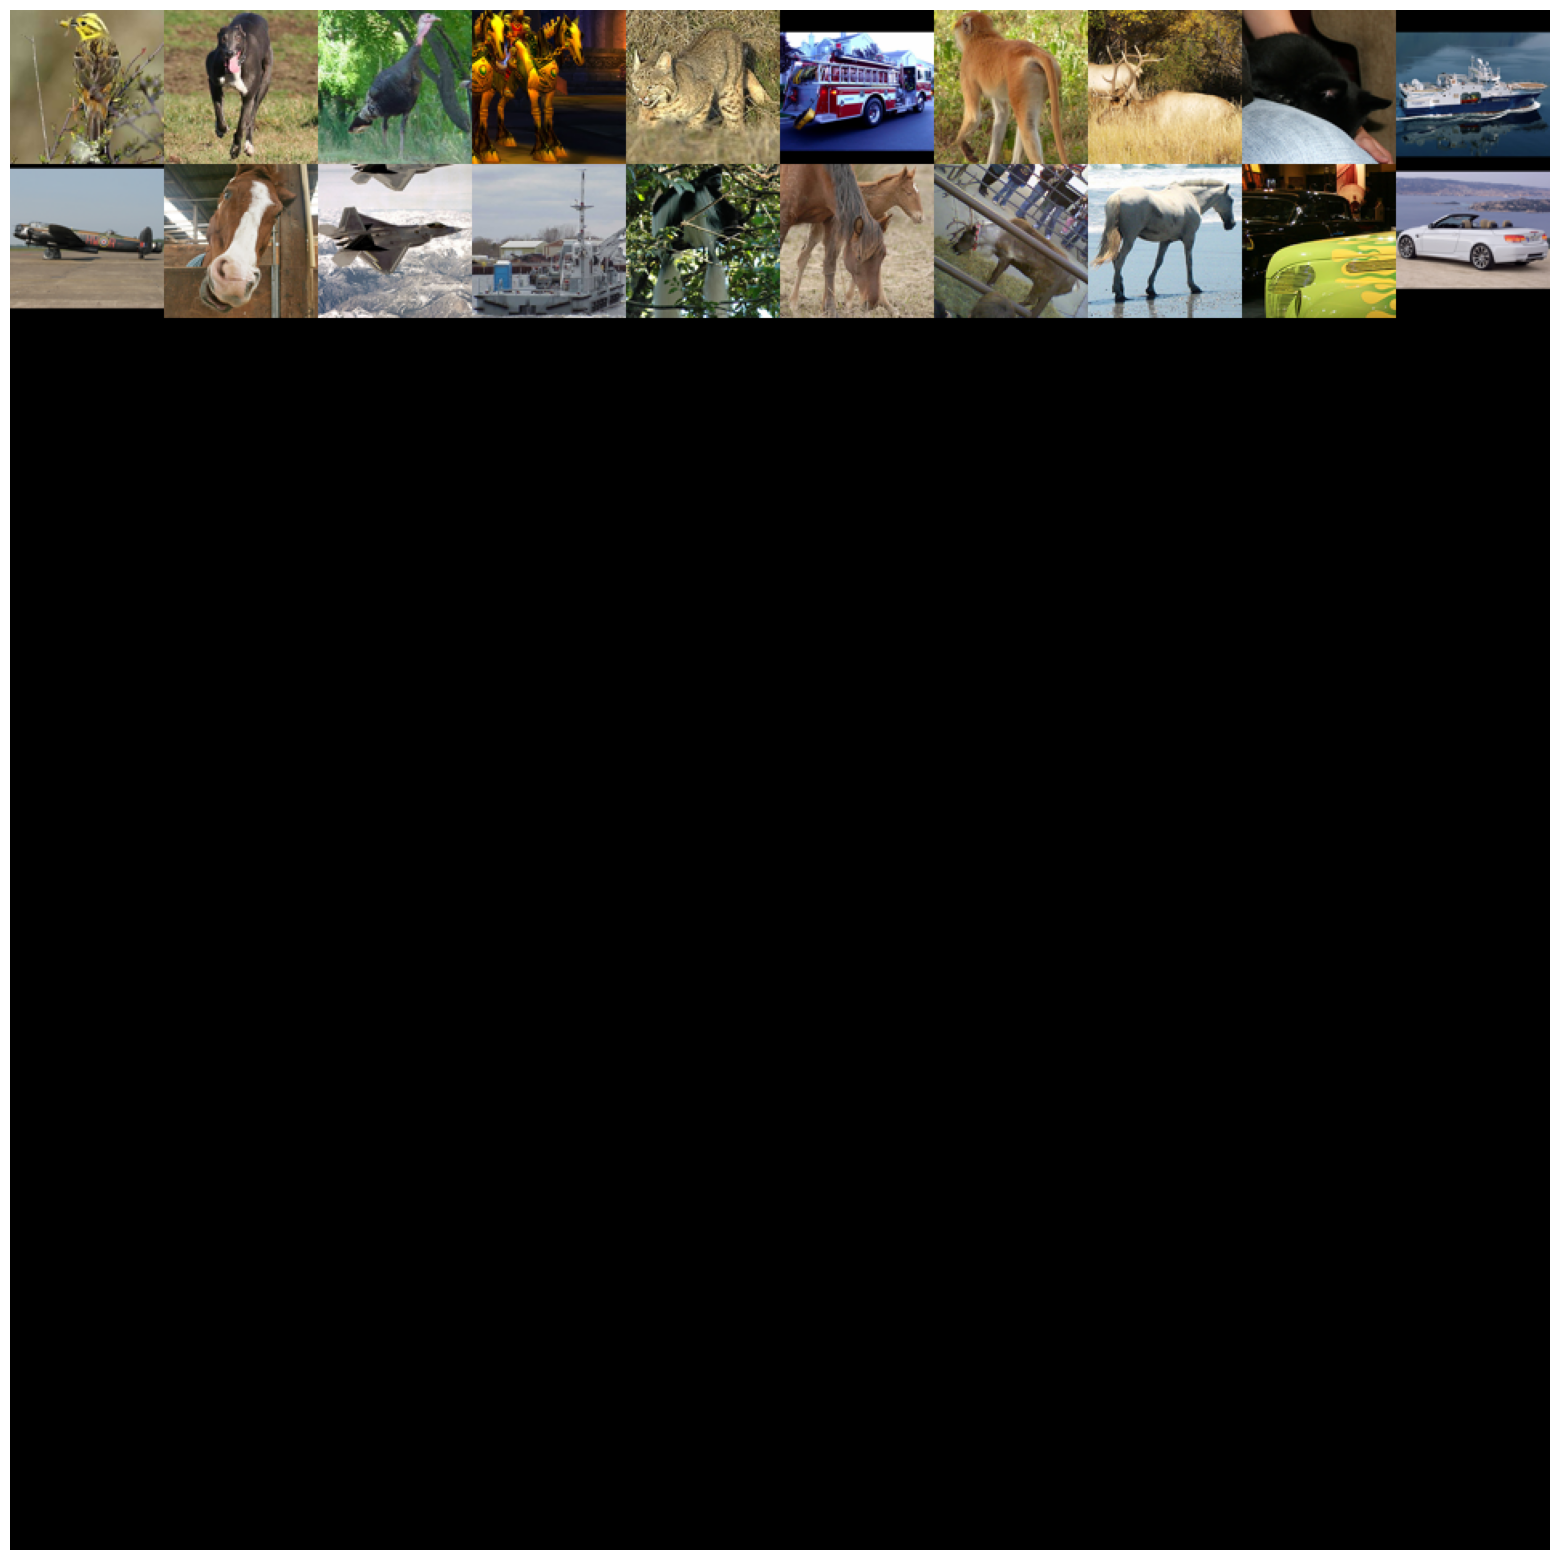

In [5]:
def plot_images(images, n_images):
  _, h, w, d = images.shape
  canvas = np.empty((h * n_images, w * n_images, d), dtype='uint8')

  for i in range(n_images):
    img_column = images[i * n_images:(1+1)*n_images]
    for j in range(n_images):
      if j >= img_column.shape[0]:
        break

      img=img_column[j]
      img = ((img * 127.5) + 127.5).clip(0, 255).astype('uint8')
      canvas[i * h:(i+1) * h, j*w:(j+1)*w] = img

  plt.figure(figsize=(2*n_images, 2 * n_images))
  plt.axis('off')
  cmap = 'gray' if d == 1 else None
  plt.imshow(canvas.squeeze(), origin = 'upper', cmap=cmap)
  plt.show()

plot_images(x_train, 10)

In [11]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
157/157 [==============================] - 3s 19ms/step - loss: 1.8591 - accuracy: 0.2914 - val_loss: 1.5972 - val_accuracy: 0.3765
Epoch 2/100
157/157 [==============================] - 2s 15ms/step - loss: 1.4263 - accuracy: 0.4752 - val_loss: 1.4517 - val_accuracy: 0.4685
Epoch 3/100
157/157 [==============================] - 2s 15ms/step - loss: 1.2515 - accuracy: 0.5430 - val_loss: 1.3444 - val_accuracy: 0.5111
Epoch 4/100
157/157 [==============================] - 2s 15ms/step - loss: 1.0957 - accuracy: 0.6000 - val_loss: 1.2341 - val_accuracy: 0.5575
Epoch 5/100
157/157 [==============================] - 2s 15ms/step - loss: 0.9481 - accuracy: 0.6536 - val_loss: 1.3114 - val_accuracy: 0.5421
Epoch 6/100
157/157 [==============================] - 2s 15ms/step - loss: 0.7775 - accuracy: 0.7290 - val_loss: 1.3454 - val_accuracy: 0.5573
Epoch 7/100
157/157 [==============================] - 2s 15ms/step - loss: 0.6494 - accuracy: 0.7698 - val_loss: 1.4503 - val_accuracy:

157/157 [==============================] - 2s 15ms/step - loss: 1.5959e-05 - accuracy: 1.0000 - val_loss: 5.4862 - val_accuracy: 0.5430
Epoch 58/100
157/157 [==============================] - 2s 15ms/step - loss: 1.4614e-05 - accuracy: 1.0000 - val_loss: 5.5136 - val_accuracy: 0.5428
Epoch 59/100
157/157 [==============================] - 2s 15ms/step - loss: 1.3377e-05 - accuracy: 1.0000 - val_loss: 5.5425 - val_accuracy: 0.5426
Epoch 60/100
157/157 [==============================] - 2s 15ms/step - loss: 1.2275e-05 - accuracy: 1.0000 - val_loss: 5.5709 - val_accuracy: 0.5428
Epoch 61/100
157/157 [==============================] - 2s 15ms/step - loss: 1.1266e-05 - accuracy: 1.0000 - val_loss: 5.5991 - val_accuracy: 0.5433
Epoch 62/100
157/157 [==============================] - 2s 15ms/step - loss: 1.0344e-05 - accuracy: 1.0000 - val_loss: 5.6267 - val_accuracy: 0.5436
Epoch 63/100
157/157 [==============================] - 2s 15ms/step - loss: 9.4950e-06 - accuracy: 1.0000 - val_loss: 

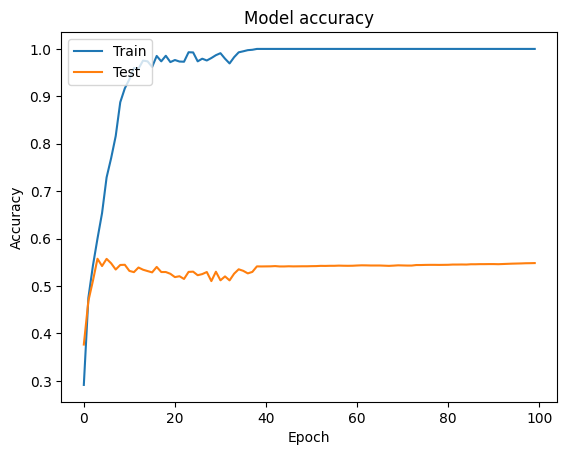

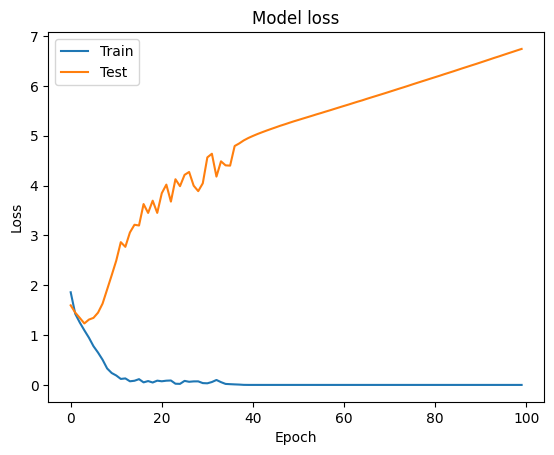

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()